# Replicating German Reunification study from [Abadie, Diamond and Hainmueller (2015)](https://web.stanford.edu/~jhain/Paper/AJPS2015a.pdf)

This notebook is meant provide a worked example of how the package can be used, and how to interpret the different plots.

In this example, we replicate [Abadie, Diamond and Hainmueller (2015)](https://web.stanford.edu/~jhain/Paper/AJPS2015a.pdf) which estimates the economic impact of the 1990 German reunification on West Germany using the synthetic control method. We perform the replication using both the ordinary Synthetic Control and the Differenced Synthetic Control implemented in this package.

In [2]:
#Import packages
import pandas as pd
import numpy as np

from SyntheticControlMethods import Synth, DiffSynth

In [3]:
#Import German Reunification data from paper
#Can be found in /datasets folder in repo
data = pd.read_csv("datasets/german_reunification.csv")
data = data.drop(columns="code", axis=1)
data.head()

,country,year,gdp,infrate,trade,schooling,invest60,invest70,invest80,industry
0,USA,1960,2879,NaN,9.693181,43.799999,NaN,NaN,NaN,NaN
1,USA,1961,2929,1.075182,9.444655,NaN,NaN,NaN,NaN,NaN
2,USA,1962,3103,1.116071,9.429324,NaN,NaN,NaN,NaN,NaN
3,USA,1963,3227,1.214128,9.470706,NaN,NaN,NaN,NaN,NaN
4,USA,1964,3420,1.308615,9.725879,NaN,NaN,NaN,NaN,NaN


### Variable descriptions and data sources:
* **GDP per Capita (PPP, 2002 USD):** Source: OECD National Accounts (retrieved via the OECD Health Database). Data for West Germany was obtained from Statistisches Bundesamt 2005 (Arbeitskreis “Volkswirtschaftliche Gesamtrechnungen der Lander”) and converted using PPP ¨monetary conversion factors (retrieved from the OECD Health Database).  
* **Investment Rate:** Ratio of real domestic investment (private plus public) to real GDP. The data are reported in five-year averages. Source: Barro, Robert Joseph, and Jong-wha Lee. 1994. “Data Set for a Panel of 138 Countries.” Available at http://www.nber.org/pub/barro.lee/.  
* **Schooling**: Percentage of secondary school attained in the total population aged 25 and older. The data are reported in five-year increments. Source: Barro, Robert Joseph, and Jong-wha Lee. 2000. “International Data on Educational Attainment: Updates and Implications.” CID Working Paper No. 42, April 2000 – Human Capital Updated Files.  
* **Industry**: industry share of value added. Source: World Bank WDI Database 2005 and Statistisches Bundesamt 2005.  
* **Inflation**: annual percentage change in consumer prices (base year 1995). Source: World Development Indicators Database 2005 and Statistisches Bundesamt 2005.  
* **Trade Openness**: Export plus imports as percentage of GDP. Source: World Bank: World Development Indicators CD-ROM 2000.

In [4]:
data.describe()

,year,gdp,infrate,trade,schooling,invest60,invest70,invest80,industry
count,748.000000,748.000000,727.000000,646.000000,151.000000,17.000000,17.000000,17.000000,541.000000
mean,1981.500000,12144.141711,5.867715,53.124137,36.356954,0.287133,0.316636,25.961294,33.238438
std,12.706922,8951.553104,5.127335,26.459397,15.498088,0.044563,0.043955,4.278174,5.161249
min,1960.000000,707.000000,-0.915120,9.429324,3.500000,0.200800,0.226020,17.587999,21.592550
25%,1970.750000,3984.500000,2.468297,33.842901,26.399999,0.263380,0.297980,22.375999,29.345671
50%,1981.500000,10258.500000,4.080017,49.529579,38.000000,0.278060,0.317980,26.488001,33.067730
75%,1992.250000,18877.500000,7.510079,68.510880,46.899999,0.319880,0.332840,27.236000,36.380058
max,2003.000000,37548.000000,28.783331,149.682400,69.599998,0.372780,0.419580,34.986000,48.001259


# Replication using Synthetic Control, Synth

Synthetic Control is fit using the Synth() method which takes the following inputs:
* **data**: Type: Pandas dataframe. A pandas dataframe containing the dataset. Each row should contain one observation for a unit at a time, including the outcome and covariates. Dataset should be ordered by unit then time.
* **outcome_var**: Type: str. Name of outcome column in data, e.g. "gdp"
* **id_var**: Type: str. Name of unit indicator column in data, e.g. "country"
* **time_var**: Type: str. Name of time column in data, e.g. "year"
* **treatment_period**: Type: int. Time of first observation after the treatment took place, i.e. first observation affected by the treatment effect. E.g. 1990 for german reunification.
* **treated_unit**: Type: str. Name of the unit that recieved treatment, data["id_var"] == treated_unit
* **n_optim**: Type: int. Default: 10. Number of different initialization values for which the optimization is run. Higher number means longer runtime, but a higher change of a globally optimal solution.

In [39]:
#Fit synthetic control
#def __init__(data, outcome_var, unit_var, time_var, treatment_period, treated_unit)
sc = Synth(data, "gdp", "country", "year", 1990, "West Germany")

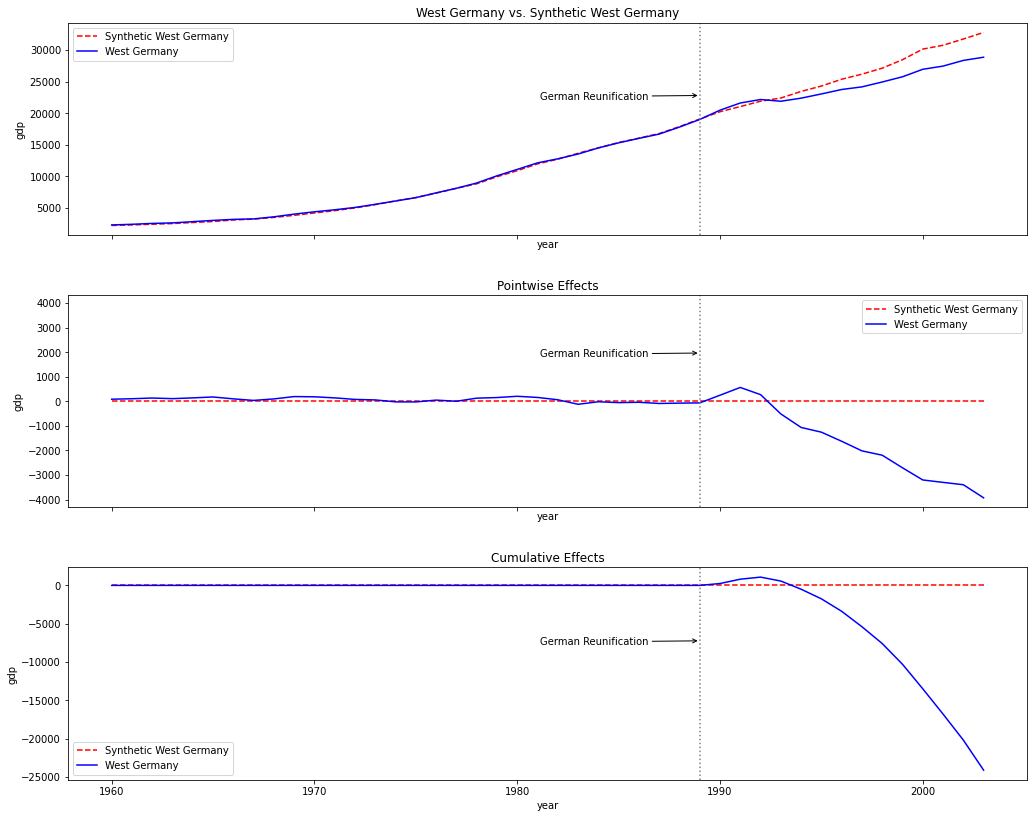

In [40]:
#Visualize
sc.plot(["original", "pointwise", "cumulative"], treated_label="West Germany", 
            synth_label="Synthetic West Germany", treatment_label="German Reunification")

The plot contains three panels. The first panel, "original", shows the data and a counterfactual prediction for the post-treatment period. The second panel, "pointwise", shows the difference between observed data and counterfactual predictions. This is the pointwise causal effect, as estimated by the model. The third panel, "cumulative", adds up the pointwise contributions from the second panel, resulting in a plot of the cumulative effect of the intervention.



In [42]:
#RMSPE for Synthetic West Germany vs. West Germany
#Treated unit is always first unit in rmspe_df
sc.original_data.rmspe_df.iloc[0]

pre_rmspe      110.635150
post_rmspe    2239.826549
post/pre        20.245162
Name: 0, dtype: float64

## Validity testing of SC
"To evaluate the credibility of our results, we conduct placebo studies where the treatment of interest is reassigned in the data to a year other than 1990 or to countries different from West Germany." (Abadie et. al, 2015)

### In-time placebo
"We first compare the reunification effect estimated above for West Germany to a placebo effect obtained after reassigning the German reunification in our data to a period before the reunification actually took place. A large placebo estimate would undermine our confidence that the results in Figure 2 are indeed indicative of the economic cost of reunification and not merely driven by lack of predictive power." (Abadie et. al, 2015)

Specifically, we call in_time_placebo(1982), which reruns the model with 1982 as the first observation after the treatment, about 8 years before the actual reunification in 1990.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/SyntheticControlMethods/plot.py:252: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(n_panels, 1, idx)


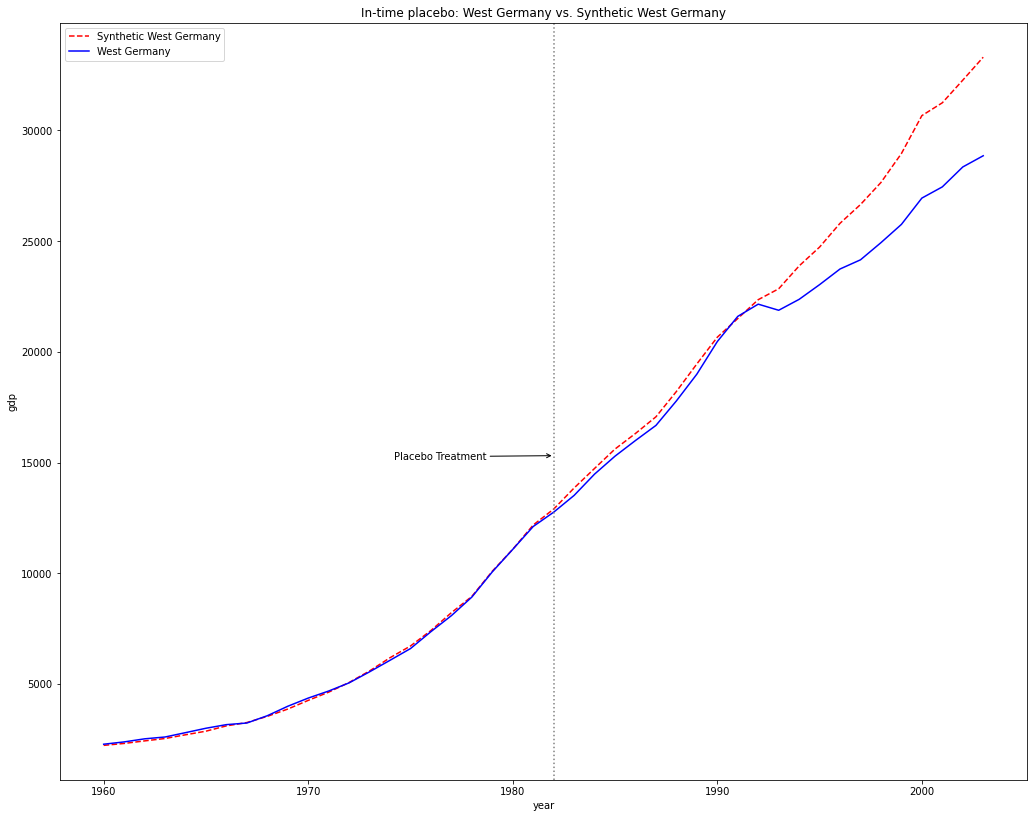

In [7]:
#In-time placebo
#Placebo treatment period is 1982, 8 years earlier
sc.in_time_placebo(1982, n_optim=10)

#Visualize
sc.plot(['in-time placebo'], 
            treated_label="West Germany",
            synth_label="Synthetic West Germany")

Observing the 'in-time placebo' plot, we see that the outcome of the synthetic control and West Germany do not diverge until the true treatment in 1990, remaining close thereuntil. This increases our confidence in the counterfactual outcome provided by the synthetic control.



### In-space placebo
An alternative way to conduct placebo studies is to reassign the treatment in the data to a comparison unit.
In this way, we can obtain synthetic control estimates for countries that did not experience the event of interest. Applying this idea to each country in the donor pool allows us to compare the estimated effect of the German reunification on West Germany to the distribution of placebo effects obtained for other countries. We will
deem the effect of the German reunification on West Germany significant if the estimated effect for West Germany
is unusually large relative to the distribution of placebo effects.

To perform this in-space placebo study, we use the method in_space_placebo(). The results are best visualized using the 'rmspe ratio' plot, which shows the distribution of Post-treatment period RMSPE / Pre-treatment period RMSPE for the true treated unit and each of the placebo treated units. The logic is that in the presence of a large treatment effect, the post-treatment difference between the a unit and its synthetic counterpart would be large relative to the pre-treatment difference.

In [8]:
#Compute in-space placebos
sc.in_space_placebo()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/SyntheticControlMethods/plot.py:230: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(n_panels, 1, idx)


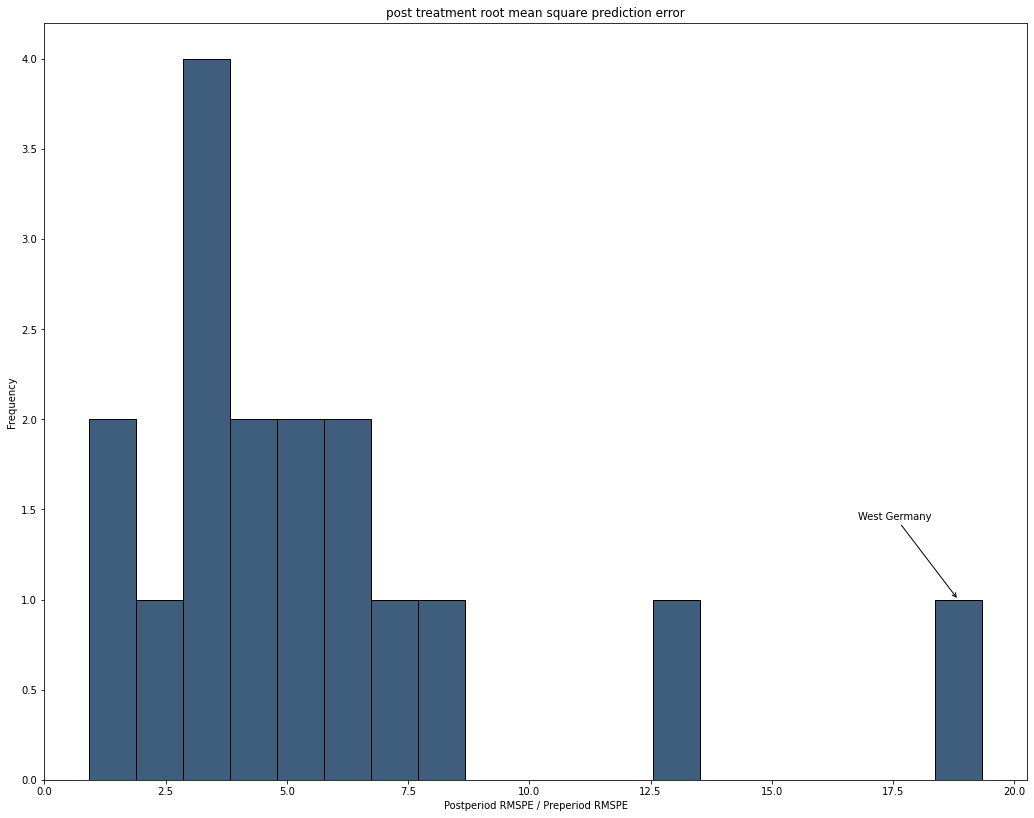

In [9]:
#Visualize
sc.plot(['rmspe ratio'], treated_label="West Germany")

West Germany is a clear outlier in the Post-period / pre-period RMSPE distribution, considerably more extreme than any of the placebo treated units. This increases our confidence in the synthetic control estimates.

# Replication using Differenced Synthetic Control, DiffSynth
Differenced Synthetic Control is fit using the DiffSynth() method, which takes the following inputs:
* **data**: Type: Pandas dataframe. A pandas dataframe containing the dataset. Each row should contain one observation for a unit at a time, including the outcome and covariates. Dataset should be ordered by unit then time.
* **outcome_var**: Type: str. Name of outcome column in data, e.g. "gdp"
* **id_var**: Type: str. Name of unit indicator column in data, e.g. "country"
* **time_var**: Type: str. Name of time column in data, e.g. "year"
* **treatment_period**: Type: int. Time of first observation after the treatment took place, i.e. first observation affected by the treatment effect. E.g. 1990 for german reunification.
* **treated_unit**: Type: str. Name of the unit that recieved treatment, data["id_var"] == treated_unit
* **n_optim**: Type: int. Default: 10. Number of different initialization values for which the optimization is run. Higher number means longer runtime, but a higher change of a globally optimal solution.

* **not_diff_cols**: Type: list. Default: []. List of column names to omit from pre-processing, e.g. compute the first difference for. Typically, columns should be included if the proportion of missing values is high. This is because the first difference is only defined for two consecutive values.


In [33]:
dsc = DiffSynth(data, "gdp", "country", "year", 1990, "West Germany", 
                  not_diff_cols=["schooling", "invest60", "invest70", "invest80"])

Because "schooling", "invest60", "invest70" and "invest80" all have 97% missing data, i.e. one observation per variable per unit, taking the first difference of them is not fruitful. If we do it before imputing missing values, the change is not defined as there is nothing to compare it to. If we do it after imputing values, regardless of which imputation strategy we use, for any unit, we would assign the same value to each time period. In turn, this would mean that the change between any two time periods would be zero. Either way, the informational value of the covariates would be lost.

This is a general weakness of the first difference approach–in these cases it is best to not compute the first difference, by including the columns in the not_diff_cols argument. That said, there are still benefits to be reaped by differencing the outcome and the remaining covariates.

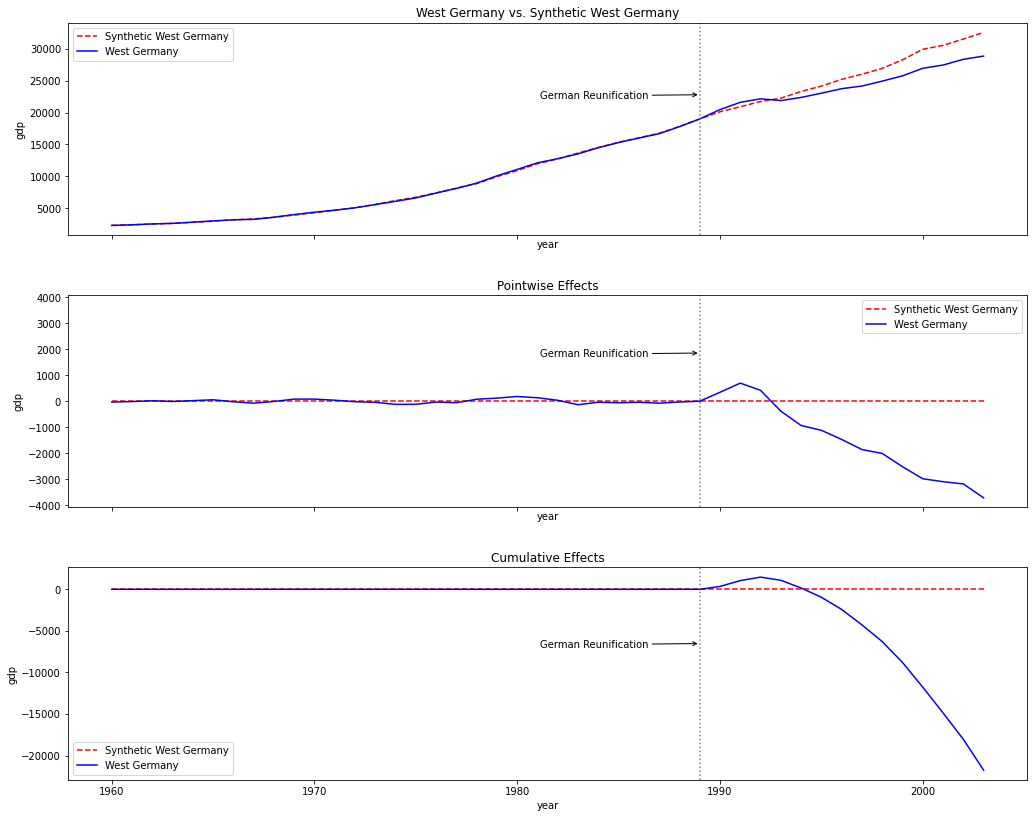

In [34]:
#Visualize
dsc.plot(["original", "pointwise", "cumulative"], treated_label="West Germany", 
            synth_label="Synthetic West Germany", treatment_label="German Reunification")

In [38]:
#RMSPE for Synthetic West Germany vs. West Germany
#Treated unit is always first unit in rmspe_df
dsc.original_data.rmspe_df.iloc[0] 

pre_rmspe       74.149039
post_rmspe    2090.732387
post/pre        28.196352
Name: 0, dtype: float64

The pre-treatment fit of the DSC is better than that of the SC. The estimated treatment effect is also somewhat lower. On the whole, however, the estimates are largely in agreement.

## Validity testing of DSC
The validity tests for DSC work and can be interpreted the same way as they are for SC.

### In-time placebo

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/SyntheticControlMethods/plot.py:252: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(n_panels, 1, idx)


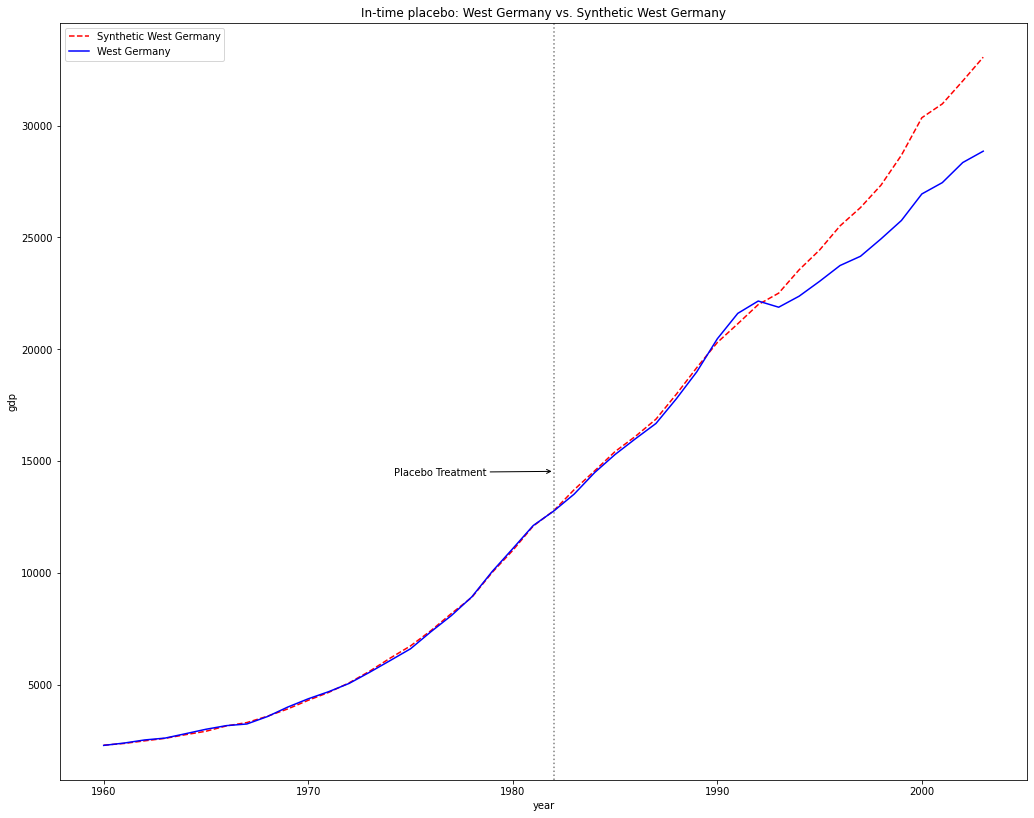

In [15]:
#In-time placebo
#Placebo treatment period is 1982, 8 years earlier
dsc.in_time_placebo(1982)

#Visualize
dsc.plot(['in-time placebo'], 
            treated_label="West Germany",
            synth_label="Synthetic West Germany")

Note the striking similarity of the in-time placebo synthetic control unit and the real synthetic control unit generated by DiffSynth.

### In-space placebo

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/SyntheticControlMethods/plot.py:230: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(n_panels, 1, idx)


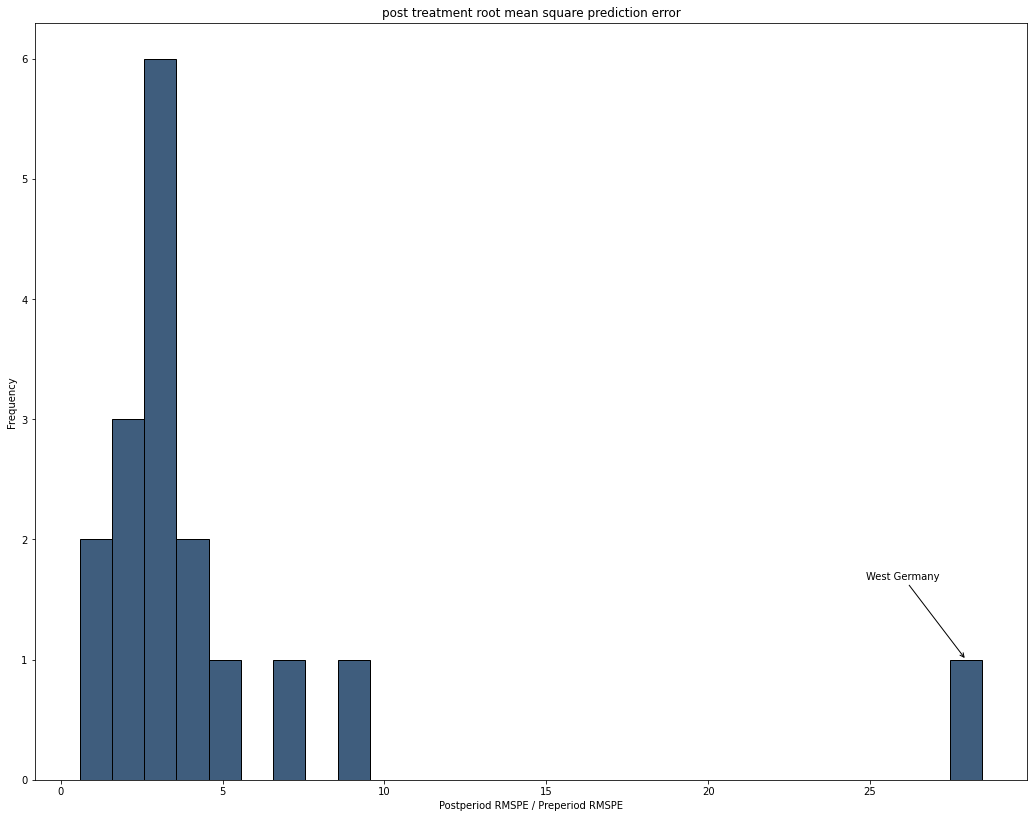

In [16]:
#Compute in-space placebos
dsc.in_space_placebo()

#Visualize
dsc.plot(['rmspe ratio'], 
            treated_label="West Germany")

The RMSPE ratio of West Germany is considerably higher using the DSC as compared to SC (28 vs 18). Simultaneously, the distribution of placebo units is grouped even tighter towards 0. On the whole, this means that the synthetic control estimate of West Germany is comparably more extreme using DSC, as compared to SC. 